In [2]:
# For number crunching
import numpy as np
import pandas as pd

# For visualisation
import matplotlib.pyplot as pl 

# For prediction 
import sklearn

# Misc
from itertools import cycle
import json 
import os

UsageError: Line magic function `%` not found.


In [4]:
print('  numpy version: {}'.format(np.__version__))
print(' pandas version: {}'.format(pd.__version__))
print('   json version: {}'.format(json.__version__))
print('sklearn version: {}'.format(sklearn.__version__))

  numpy version: 1.19.2
 pandas version: 1.2.3
   json version: 2.0.9
sklearn version: 0.24.1


In [6]:
import sys
nb_dir = os.path.split(os.getcwd())
nb_dir2 = nb_dir[0]+'/'+nb_dir[1]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
if nb_dir2 not in sys.path:
    sys.path.append(nb_dir2)

public_data_path = nb_dir2+'/data' # 

# metadata_path = '/Users/fl20994/Documents/IAI_CDT/TB2/Applied_Data_Science/SPHERE/public_data/metadata'
# metadata_path = '../public_data/metadata'
metadata_path = nb_dir2+'/data/metadata'

In [10]:
from visualise_data import Sequence

import warnings
warnings.filterwarnings('ignore')

"""
For every data modality, we will extract some very simple features: the mean, min, max, median, and standard 
deviation of one second windows. We will put function pointers in a list called 'feature_functions' so that we 
can easily call these on our data for later
"""
feature_functions = [np.mean, np.std, np.min, np.median, np.max, np.sum]
feature_names = ['mean', 'std', 'min', 'median', 'max', 'sum']

# We will keep the number of extracted feature functions as a parameter 
num_ff = len(feature_functions)

# We will want to keep track of the feature names for later, so we will collect these in the following list: 
column_names = []

# These are the modalities that are available in the dataset, and the .iterate() function returns the data 
# in this order
modality_names = ['acceleration', 'rssi', 'pir', 'video_living_room', 'video_kitchen', 'video_hallway']

"""
Iterate over all training directories
"""
for train_test in ('train', 'test', ): 
    if train_test is 'train': 
        print ('Extracting features from training data.\n')
    else: 
        print ('\n\n\nExtracting features from testing data.\n')
        
    for fi, file_id in enumerate(os.listdir('{}/{}/'.format(public_data_path, train_test))):

        if ".DS_Store" in str(file_id):
            continue

        stub_name = str(file_id).zfill(5)
        


        if train_test is 'train' or np.mod(fi, 50) == 0:
            print ("Starting feature extraction for {}/{}".format(train_test, stub_name))

        # Use the sequence loader to load the data from the directory. 
        data = Sequence(metadata_path, '{}/{}/{}'.format(public_data_path, train_test, stub_name))
        data.load()

        """
        Populate the column_name list here. This needs to only be done on the first iteration
        because the column names will be the same between datasets. 
        """
        if len(column_names) == 0:
            for lu, modalities in data.iterate():#(ms=1000):
                for modality, modality_name in zip(modalities, modality_names):
                    for column_name, column_data in modality.transpose().iterrows():
                        for feature_name in feature_names:
                            column_names.append('{0}_{1}_{2}'.format(modality_name, column_name, feature_name))

                # Break here 
                break 

        """
        Here, we will extract some features from the data. We will use the Sequence.iterate function. 

        This function partitions the data into one-second dataframes for the full data sequence. The first element 
        (which we call lu) represents the lower and upper times of the sliding window, and the second is a list of
        dataframes, one for each modality. The dataframes may be empty (due to missing data), and feature extraction 
        has to be able to cope with this! 

        The list rows will store the features extracted for this dataset
        """
        rows = []

        for ri, (lu, modalities) in enumerate(data.iterate()): #(ms=1000)):
            row = []

            """
            Iterate over the sensing modalities. The order is given in modality_names. 

            Note: If you want to treat each modality differently, you can do the following: 

            for ri, (lu, (accel, rssi, pir, vid_lr, vid_k, vid_h)) in enumerate(data.iterate()):
                row.extend(extract_accel(accel))
                row.extend(extract_rssi(rssi))
                row.extend(extract_pir(pir))
                row.extend(extract_video(vid_lr, vid_k, vid_h))

            where the extract_accel/extract_rssi/extract_pir/extract_video functions are designed by you. 
            In the case here, we extract the same features from each modality, but optimal performance will 
            probably be achieved by considering different features for each modality. 
            """

            for modality in modalities:
                """
                The accelerometer dataframe, for example, has three columns: x, y, and z. We want to extract features 
                from all of these, and so we iterate over the columns here. 
                """
                for name, column_data in modality.transpose().iterrows():
                    if len(column_data) > 3:
                        """
                        Extract the features stored in feature_functions on the column data if there is sufficient 
                        data in the dataframe. 
                        """
                        row.extend(map(lambda ff: ff(column_data), feature_functions))

                    else:
                        """
                        If no data is available, put nan placeholders to keep the column widths consistent
                        """
                        row.extend([np.nan] * num_ff)

            # Do a quick sanity check to ensure that the feature names and number of extracted features match
            assert len(row) == len(column_names)

            # Append the row to the full set of features
            rows.append(row)

            # Report progress 
            # if train_test is 'train':
            #     if np.mod(ri + 1, 50) == 0:
            #         print ("{:5}".format(str(ri + 1))),

            #     if np.mod(ri + 1, 500) == 0:
            #         print

        """
        At this stage we have extracted a bunch of simple features from the data. In real implementation, 
        it would be advisable to look at more interesting features, eg

          * acceleration: link
          * environmental: link
          * video: link

        We will save these features to a new file called 'columns.csv' for use later. This file will be located 
        in the name of the training sequence. 
        """
        df = pd.DataFrame(rows)
        df.columns = column_names
        df.to_csv('{}/{}/{}/columns_1000ms.csv'.format(public_data_path, train_test, stub_name), index=False)

        if train_test is 'train' or np.mod(fi, 50) == 0:
            if train_test is 'train': 
                print ("Finished feature extraction for {}/{}\n".format(train_test, stub_name))

Extracting features from training data.

Starting feature extraction for train/00009
Finished feature extraction for train/00009

Starting feature extraction for train/00007
Finished feature extraction for train/00007

Starting feature extraction for train/00006
Finished feature extraction for train/00006

Starting feature extraction for train/00001
Finished feature extraction for train/00001

Starting feature extraction for train/00008
Finished feature extraction for train/00008

Starting feature extraction for train/00004
Finished feature extraction for train/00004

Starting feature extraction for train/00003
Finished feature extraction for train/00003

Starting feature extraction for train/00002
Finished feature extraction for train/00002

Starting feature extraction for train/00005
Finished feature extraction for train/00005

Starting feature extraction for train/00010
Finished feature extraction for train/00010




Extracting features from testing data.

Starting feature extractio

In [11]:
df.head(3)

,acceleration_x_mean,acceleration_x_std,acceleration_x_min,acceleration_x_median,acceleration_x_max,acceleration_x_sum,acceleration_y_mean,acceleration_y_std,acceleration_y_min,acceleration_y_median,...,video_hallway_bb_3d_flt_y_min,video_hallway_bb_3d_flt_y_median,video_hallway_bb_3d_flt_y_max,video_hallway_bb_3d_flt_y_sum,video_hallway_bb_3d_flt_z_mean,video_hallway_bb_3d_flt_z_std,video_hallway_bb_3d_flt_z_min,video_hallway_bb_3d_flt_z_median,video_hallway_bb_3d_flt_z_max,video_hallway_bb_3d_flt_z_sum
0,0.4847,0.361156,-0.120,0.550,0.898,9.694,-0.7798,0.157128,-1.074,-0.707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.3935,0.308849,-0.026,0.365,1.096,7.870,-0.4990,0.567171,-1.314,-0.531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.3853,0.226490,-0.194,0.456,0.696,7.706,-0.4958,0.283972,-0.916,-0.537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Load Data

In [12]:
"""
We will define two convenience function to load the extracted features and their 
"""


def load_sequence(file_id):
    filename = str(file_id).zfill(5) # zfill fills with 5 zeros at the beginning of the string

    df = pd.read_csv('{}/train/{}/columns_1000ms.csv'.format(public_data_path, filename))
    data = df.values
    target = np.asarray(pd.read_csv('{}/train/{}/targets.csv'.format(public_data_path, filename)))[:, 2:]

    return data, target


def load_sequences(file_ids):
    x_es = []
    y_es = []

    for file_id in file_ids:
        data, target = load_sequence(file_id)

        x_es.append(data)
        y_es.append(target)

    return np.row_stack(x_es), np.row_stack(y_es)

In [13]:
# Load the training and testing data - all from the train directory(?)
# The functions above grab the dataframes from each of the train directories and combine them together. (The dfs in those directories are themselves combinations of the data from the different modalities)
train_x, train_y = load_sequences([1, 2, 3, 4, 5, 6, 7, 8])
test_x, test_y = load_sequences([9, 10])

# Data Imputation

In [14]:
print ("Check whether the train/test features are all finite (before imputation)")
print ('All training data finite:', np.all(np.isfinite(train_x)))
print ('All testing data finite:', np.all(np.isfinite(test_x)))
print 

# We will want to impute the missing data 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
imputer.fit(train_x)

train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

print ("Check whether the train/test features are all finite (after imputation)")
print ('All training data finite:', np.all(np.isfinite(train_x)))
print ('All testing data finite:', np.all(np.isfinite(test_x)))
print 

# Load the label names 
labels = json.load(open(metadata_path + '/annotations.json'))
n_classes = len(labels)

"""
Note, not all data is annotated, so we select only the annotated rows
"""
train_y_has_annotation = np.isfinite(train_y.sum(1))
train_x = train_x[train_y_has_annotation]
train_y = train_y[train_y_has_annotation]

test_y_has_annotation = np.isfinite(test_y.sum(1))
test_x = test_x[test_y_has_annotation]
test_y = test_y[test_y_has_annotation]


"""
Print simple statistics regarding the number of instances
"""
print ("Training data shapes:")
print ("train_x.shape: {}".format(train_x.shape))
print ("train_y.shape: {}".format(train_y.shape))
print 

print ("Testing data shapes")
print ("test_x.shape: {}".format(test_x.shape))
print ("test_y.shape: {}".format(test_y.shape))

Check whether the train/test features are all finite (before imputation)
All training data finite: False
All testing data finite: False
Check whether the train/test features are all finite (after imputation)
All training data finite: True
All testing data finite: True
Training data shapes:
train_x.shape: (12513, 366)
train_y.shape: (12513, 20)
Testing data shapes
test_x.shape: (3591, 366)
test_y.shape: (3591, 20)


# Class Weights

In [18]:
activity_names = json.load(open(metadata_path + '/annotations.json', 'r'))
class_weights = np.asarray(json.load(open(metadata_path + '/class_weights.json', 'r')))

class_prior = train_y.mean(0)

df = pd.DataFrame({
        'Activity': activity_names, 
        'Class Weight': class_weights,
        'Prior Class Distribution': class_prior
    })

df.set_index('Activity', inplace=True)
# # reset colour palette
# current_palette = cycle(sns.color_palette())
# df.plot(
#     kind='bar',
#     width=1.0,
#     subplots=True,
#     color=[next(current_palette), next(current_palette)], 
# )

# Prior Class Model

Before looking at an actual classification model, it is useful to look at a very simple baseline: the prior class distribution predictor. With this model, we compute the prior distribution of the training data, and use this as our predictions for all new instances. This is not a very useful model because it doesn't look at any sensor data.

In [22]:
from visualise_data import SequenceVisualisation

plotter = SequenceVisualisation(metadata_path, public_data_path + '/train/00001')

annotation_names = plotter.targets.columns.difference(['start', 'end'])

se_cols = ['start', 'end']

num_lines = 0

with open('submission_prior_baseline.csv', 'w') as fil: 
    fil.write(','.join(['record_id'] + se_cols + annotation_names.tolist()))
    fil.write('\n')
            
    for te_ind_str in sorted(os.listdir(os.path.join(public_data_path, 'test'))):
        te_ind = int(te_ind_str)

        meta = json.load(open(os.path.join(public_data_path, 'test', te_ind_str, 'meta.json')))

        starts = range(meta['end'])
        ends = range(1, meta['end'] + 1)

        for start, end in zip(starts, ends):
            row = [te_ind, start, end] + class_prior.tolist()

            fil.write(','.join(map(str, row)))
            fil.write('\n')
            
            num_lines += 1
            
print ("{} lines written.".format(num_lines))

16689 lines written.


# KNN

As we said earlier, we are going to use a k nearest neighbours classifier. The basic idea is that we find the training data that 'look' most similar to our new test data, and predict the average of those similar neighbours.

In [24]:
from sklearn.neighbors import NearestNeighbors


In [26]:
"""
Define a simple class that inherits from sklearn.neighbors.NearestNeighbors. 
We will adjust the fit/predict as necessary
"""
class ProbabilisticKNN(NearestNeighbors): 
    def __init__(self, n_neighbors): 
        super(ProbabilisticKNN, self).__init__(n_neighbors)
        
        self.train_y = None
        
    def fit(self, train_x, train_y): 
        """
        The fit function requires both train_x and train_y. 
        See 'The selected model' section above for explanation
        """
        
        self.train_y = np.copy(train_y)
        
        super(ProbabilisticKNN, self).fit(train_x)
        
    def predict_proba(self, test_x): 
        """
        This function finds the k closest instances to the unseen test data, and 
        averages the train_labels of the closest instances. 
        """
        
        # Find the nearest neighbours for the test set
        test_neighbours = self.kneighbors(test_x, return_distance=False)
        
        # Average the labels of these for prediction
        return np.asarray(
            [self.train_y[inds].mean(0) for inds in test_neighbours]
        )

# Learn the KNN model 
nn = ProbabilisticKNN(n_neighbors=11)
nn.fit(train_x, train_y)

# Predict on the test instances
test_predicted = nn.predict_proba(test_x)

In [47]:
print(test_predicted[6,:])
print(test_y[6,:])

[0.11363636 0.         0.         0.         0.09090909 0.
 0.         0.         0.         0.         0.70909091 0.
 0.         0.         0.         0.         0.         0.
 0.         0.08636364]
[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]


In [42]:
# Test the effect of K
# brier score measures the accuracy of probabilistic predictions

def brier_score(given, predicted, weight_vector): 
    return np.power(given - predicted, 2.0).dot(weight_vector).mean()

brier_scores = []

k_range = np.power(2, range(8))
for k in k_range: 
    print ("Learning model for k={:3d}".format(k)), 
    
    nn = ProbabilisticKNN(n_neighbors=k)
    nn.fit(train_x, train_y)
    
    predicted = nn.predict_proba(test_x)
    
    brier_scores.append(brier_score(test_y, predicted, class_weights))
    
    print ("score={:.5f}".format(brier_scores[-1]))

Learning model for k=  1
score=0.50682
Learning model for k=  2
score=0.39434
Learning model for k=  4
score=0.33123
Learning model for k=  8
score=0.29821
Learning model for k= 16
score=0.28477
Learning model for k= 32
score=0.28210
Learning model for k= 64
score=0.28163
Learning model for k=128
score=0.28080


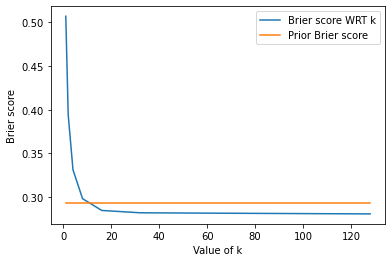

In [43]:
pl.plot(k_range, brier_scores, label='Brier score WRT k')
pl.plot([k_range[0], k_range[-1]], [prior_brier_score, prior_brier_score], label='Prior Brier score')

pl.xlabel('Value of k') 
pl.ylabel('Brier score')

pl.legend(loc=0)

Performance Evaluation

In [41]:
# Looking at the results - using the class weights here to adjust our performace evaluation.
# I guess we could just use f-score instead?
# The increase in classification performance isn't all that high in comparison to the prior model. This is because of the manner in which the class weights are specified because we have placed emphasis on the ambulation and transition activities that are harder to classify.

knn_brier_score = brier_score(test_y, test_predicted, class_weights)

print ("Brier score on test set with the KNN model")
print (knn_brier_score)
print 

# For comparison to the KNN model, test the prior class distribution  
prior_matrix = np.repeat(class_prior.reshape((1, -1)), test_y.shape[0], axis=0)
prior_brier_score = brier_score(test_y, prior_matrix, class_weights)

print ("Brier score on test using the prior class probability as a constant model")
print (prior_brier_score)
print

Brier score on test set with the KNN model
0.2904930016955408
Brier score on test using the prior class probability as a constant model
0.29301964202920805


<function print>

In [49]:
np.power(test_y - test_predicted, 2.0).dot(class_weights).mean()

0.2904930016955408

In [55]:
np.power(test_y - test_predicted, 2.0)[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.20661157,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.20661157, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [77]:
print(test_y[0,:][4])
print(test_predicted[0,:][4])


0.0
0.45454545454545453


In [78]:
np.power(test_y - test_predicted,2.0)[0,:][4]

0.20661157024793386

In [ ]:
.dot(weight_vector)